In [40]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [41]:
# Preprocessing
def preproc(dataframe):
    dataframe.index = pd.to_datetime(dataframe.index)
    return dataframe


def get_series(dataframe,col):
    series = dataframe[col]
    return series

In [42]:
# Smooth
def moving_average_smooth(series, window):
    smoothed_series = series.rolling(window=window).mean()
    return smoothed_series


def exponential_moving_average_smooth(series, alpha):
    smoothed_series = series.ewm(alpha=alpha, adjust=False).mean()
    return smoothed_series


def savgol_filter_smooth(series, window, polyorder):
    from scipy.signal import savgol_filter

    smoothed_arr = savgol_filter(series, window_length=window, polyorder=polyorder)
    smoothed_series = pd.Series(smoothed_arr, index=series.index, name=series.name)
    return smoothed_series


def lowess_smooth(series, frac):
    from statsmodels.nonparametric.smoothers_lowess import lowess

    x = np.arange(1, len(series) + 1)
    y = series.to_numpy()
    result = lowess(y, x, frac=frac)
    smoothed_arr = result[:, 1]
    smoothed_series = pd.Series(smoothed_arr, index=series.index, name=series.name)
    return smoothed_series


def spline_smooth(series, s):
    from sklearn.preprocessing import MinMaxScaler
    from scipy.interpolate import UnivariateSpline

    x = np.arange(1, len(series) + 1)
    y = series.to_numpy().reshape(-1, 1)

    mms_y = MinMaxScaler()
    scaled_y = mms_y.fit_transform(y).flatten()

    spline = UnivariateSpline(x, scaled_y, s=s)
    scaled_smoothed_y = spline(x)
    smoothed_arr = mms_y.inverse_transform(scaled_smoothed_y.reshape(-1, 1)).flatten()
    smoothed_series = pd.Series(smoothed_arr, index=series.index, name=series.name)

    return smoothed_series


def gaussian_smooth(series, sigma):
    from scipy.signal import convolve

    size = int(3 * abs(sigma) + 1)
    x = np.arange(-size, size + 1)
    kernel = np.exp(-(x**2) / (2 * sigma**2))
    kernel = kernel / np.sum(kernel)

    smoothed_arr = convolve(series.to_numpy(), kernel, mode='valid')
    padding_size = len(series) - len(smoothed_arr)
    left_pad = padding_size // 2  # 왼쪽 패딩 크기
    right_pad = padding_size - left_pad  # 오른쪽 패딩 크기

    padded_arr = np.pad(smoothed_arr, (left_pad, right_pad), constant_values=np.nan)

    smoothed_series = pd.Series(padded_arr, index=series.index, name=series.name)
    return smoothed_series

In [43]:
# Plot
def plot_series(series, smooth_func, smooth_func_params):
    plt.figure(figsize=(14, 6))
    plt.plot(series.index, series, label='RAW', c='k', alpha=0.5)
    for smooth_func_param in smooth_func_params:
        smoothed_series = smooth_func(series, *smooth_func_param)
        plt.plot(smoothed_series.index, smoothed_series, label=f'{smooth_func.__name__}_{smooth_func_param}', alpha=1)
    plt.legend()
    plt.show()

In [44]:
kospi_df = pd.read_csv("./data/kospi_ohlcv.csv", index_col=0)
kospi_df = preproc(kospi_df)
series = get_series(kospi_df, 'close')

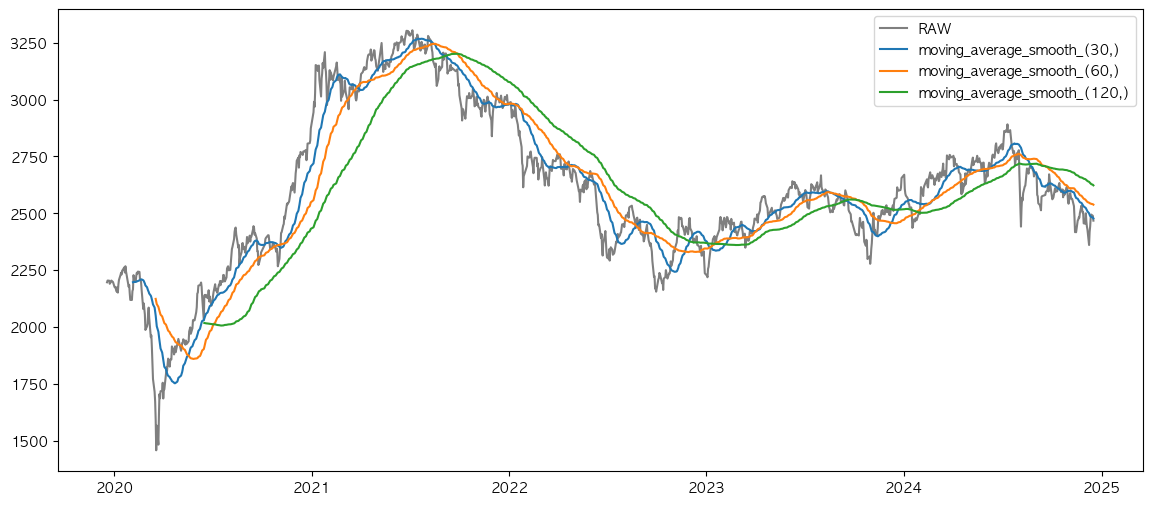

In [45]:
plot_series(series, moving_average_smooth, [(30,), (60,), (120,)])

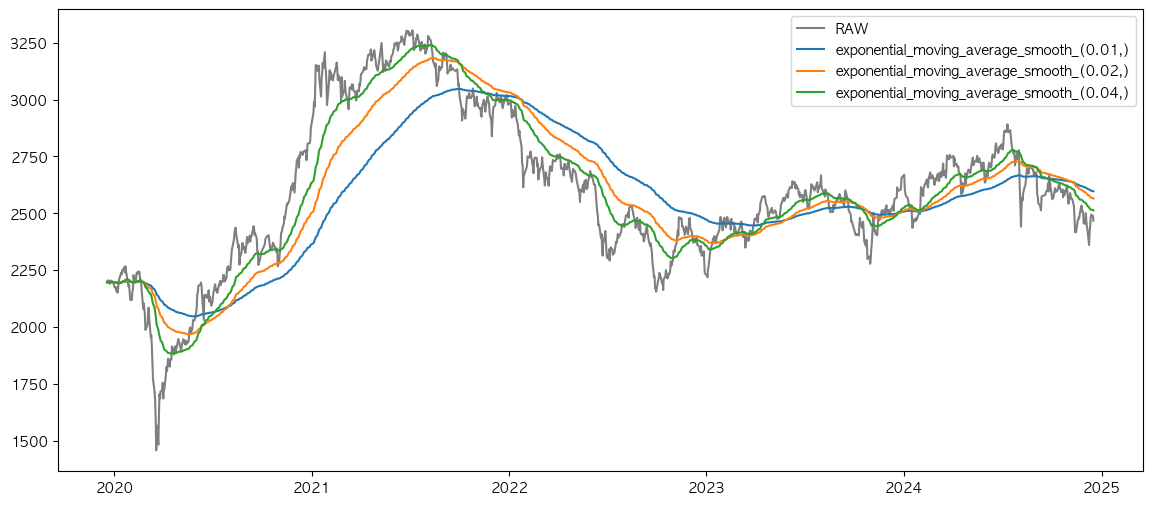

In [46]:
plot_series(series, exponential_moving_average_smooth, [(0.01,), (0.02,), (0.04,)])

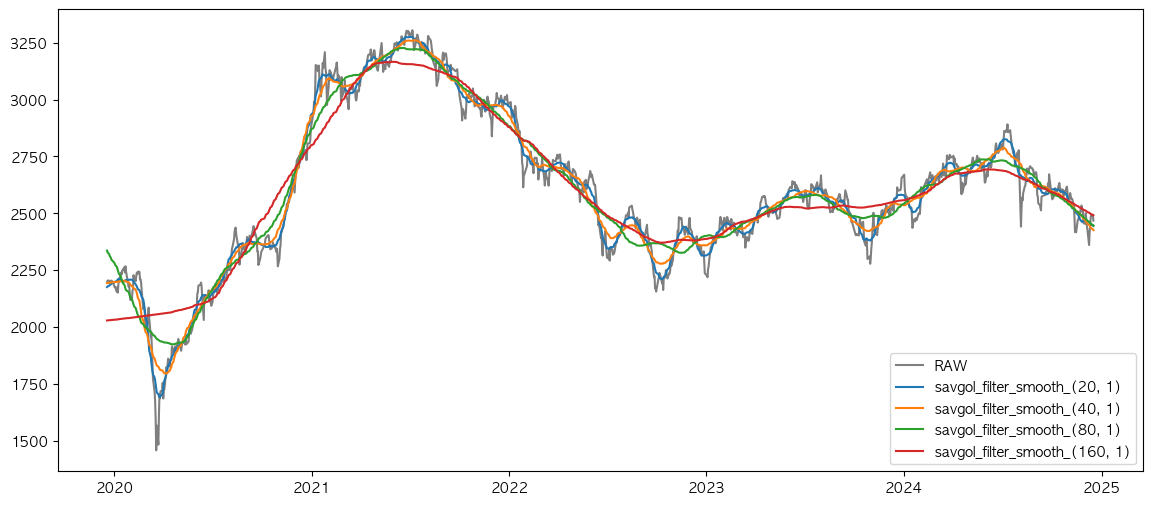

In [47]:
plot_series(series, savgol_filter_smooth, [(20, 1), (40, 1), (80, 1), (160, 1)])

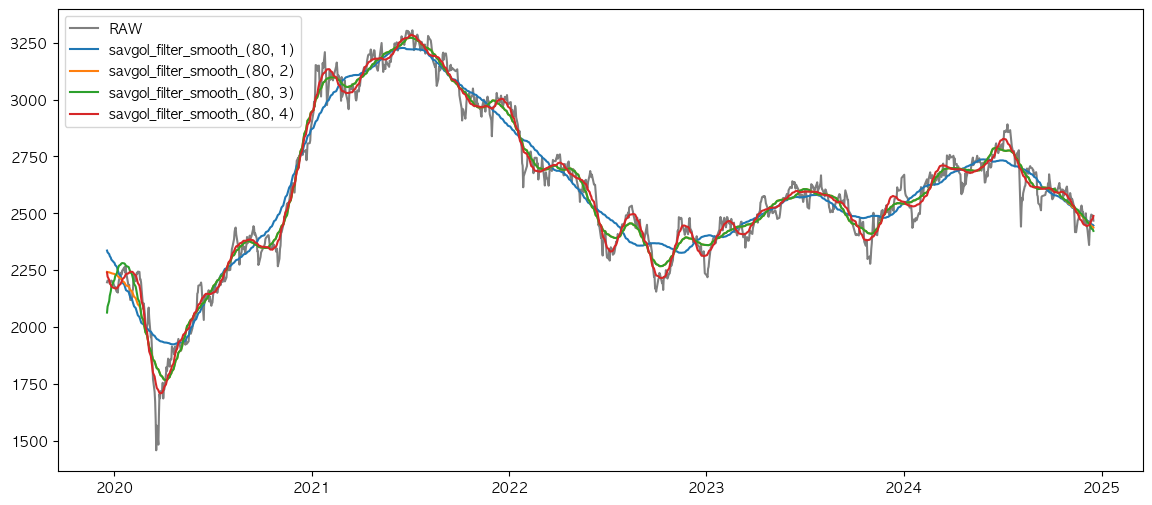

In [48]:
plot_series(series, savgol_filter_smooth, [(80, 1), (80, 2), (80, 3), (80, 4)])

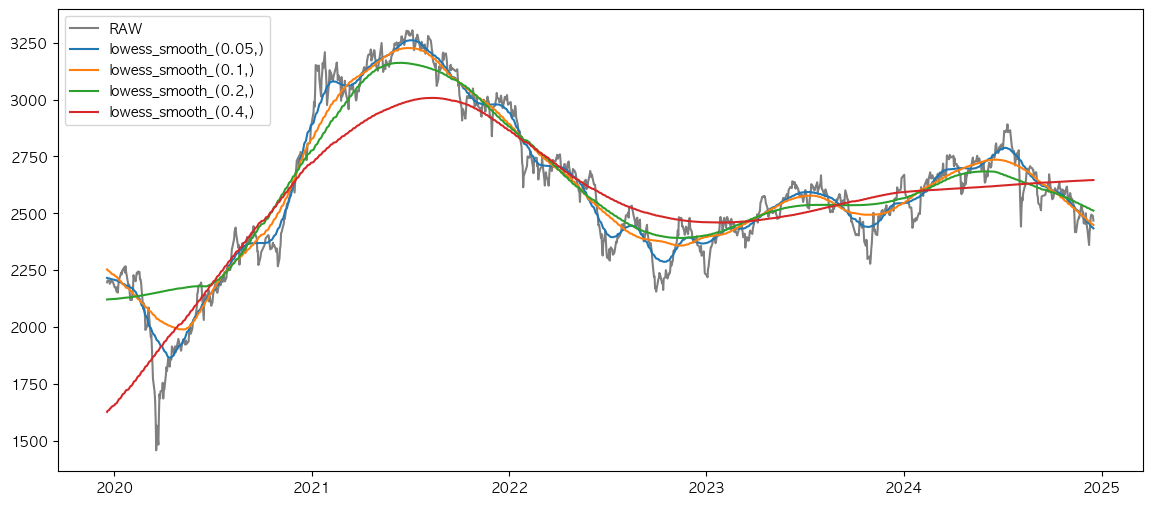

In [49]:
plot_series(series, lowess_smooth, [(0.05,), (0.1,), (0.2,), (0.4,)])

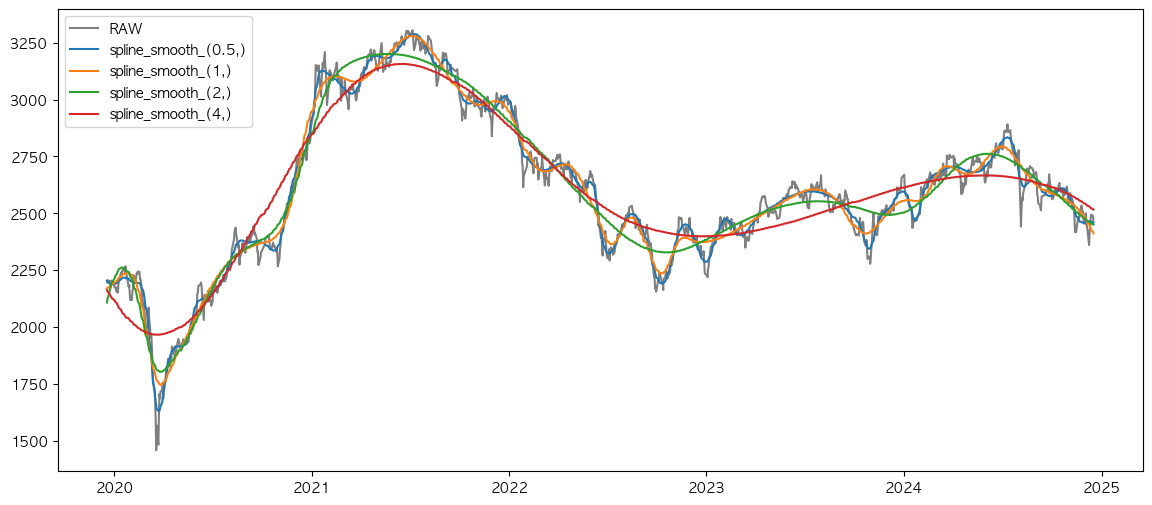

In [50]:
plot_series(series, spline_smooth, [(0.5,), (1,), (2,), (4,)])

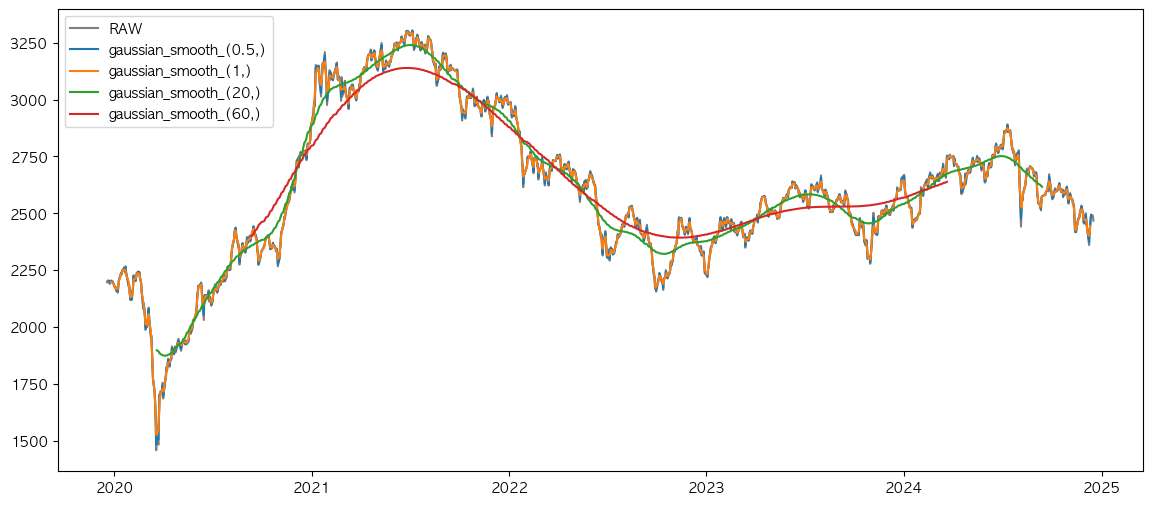

In [51]:
plot_series(series, gaussian_smooth, [(0.5,), (1,), (20,), (60,)])